# Asset Pricing Homework 3

*By Daniel Deutsch, José Lucas Barretto and Ziyad Bekkaoui*.

In [1]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from statsmodels.tsa import stattools as smt
from statsmodels.formula import api as smf

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Importing Datasets

Firstly, we load the data into dataframes. 

For this homework we decided to work with Ford's stock data because it would be nice to averiguate, specially, the 2008 financial crisis and the pendemic effect over its stock prices. As one can verify below, we chose to work with a **monthly frequency between the years 2000 and 2020** due to its availability and because od the fact that it is in a better scale for working with the dividends, given its frequency.

We obtain the data from two different sources.

- Candles and dividends: [Yahoo Finance](https://finance.yahoo.com/);
- Risk Free Rate: [https://fred.stlouisfed.org/series/IRLTLT01USM156N?fbclid=IwAR06pLCiBhQBF8GcMPFIm1sOkVlO_ZkytrM2OerSlLjjDsyAymV26azJYeQ](https://fred.stlouisfed.org/series/IRLTLT01USM156N?fbclid=IwAR06pLCiBhQBF8GcMPFIm1sOkVlO_ZkytrM2OerSlLjjDsyAymV26azJYeQ)

Once the data is loaded, we can apply the log-transform to our time series.

In [3]:
# Defines the stock
stock = yf.Ticker('F')

# Obtains the OHLCV dataframe
df_candles = stock.history(start='2000-01-02', end='2020-12-31').reset_index()
df_candles['Date'] = df_candles['Date'].astype('datetime64[M]')
df_candles.drop_duplicates(subset='Date', keep='last', inplace=True, ignore_index=True)
df_candles = df_candles[['Date', 'Close']]
df_candles.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

# Obtains the dividends dataframe
df_dividends = stock.dividends.to_frame().reset_index()
df_dividends.rename(columns={'Date': 'date', 'Dividends': 'dividend'}, inplace=True)
df_dividends['date'] = df_dividends['date'].astype('datetime64[M]')

# Obtains the risk free rate dataframe
df_rf = pd.read_csv("./datasets/risk_free_rate.csv", parse_dates=['date'], names=['date', 'rf'], skiprows=1).sort_values('date', ignore_index=True)

# Adds only used values to the dataframe
df = pd.merge(df_candles[['date', 'close']], df_dividends, on='date', how='left')
df = df.merge(df_rf, on='date', how='left')
df.set_index('date', inplace=True)

# Pads dividend data
df['dividend'] = df['dividend'].pad()

# Applies log-transform to the price and dividends
df['log_close'] = np.log(df['close'])
df['log_dividend'] = np.log(df['dividend'])

# Sets risk free rate to percentage value
df['rf'] /= 100

# Remove Non Available Numbers
df.dropna(inplace=True)

# Deletes unused dataframes to clear memory
del df_dividends, df_candles, df_rf

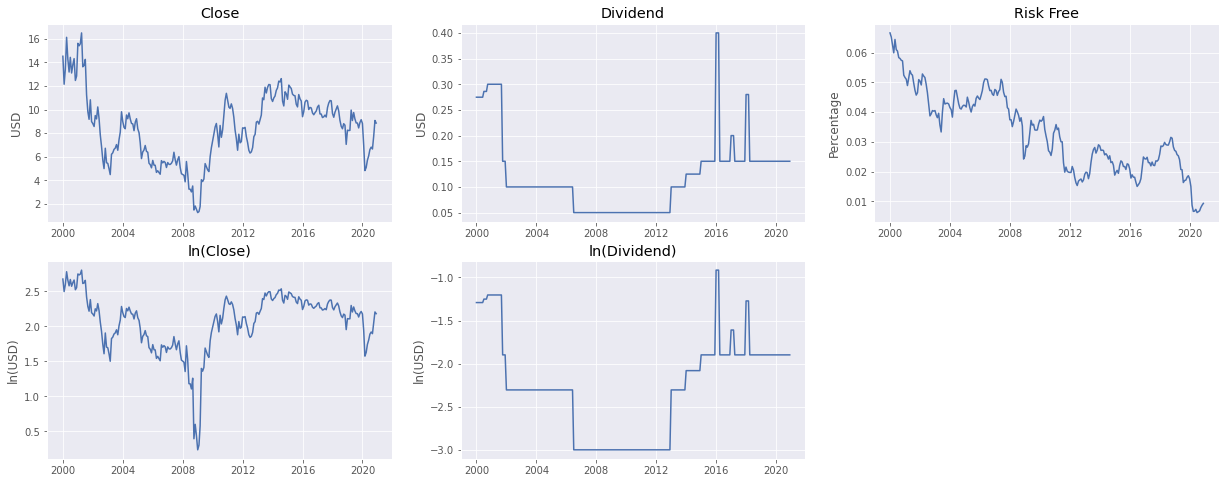

In [4]:
# Plots
fig, axs = plt.subplots(2, 3, figsize=(21, 8))
axs[0, 0].plot(df['close'])
axs[0, 0].set_title("Close")
axs[0, 0].set_ylabel("USD")
axs[1, 0].plot(df['log_close'])
axs[1, 0].set_title("ln(Close)")
axs[1, 0].set_ylabel("ln(USD)")
axs[0, 1].plot(df['dividend'])
axs[0, 1].set_title("Dividend")
axs[0, 1].set_ylabel("USD")
axs[1, 1].plot(df['log_dividend'])
axs[1, 1].set_title("ln(Dividend)")
axs[1, 1].set_ylabel("ln(USD)")
axs[0, 2].plot(df['rf'])
axs[0, 2].set_title("Risk Free")
axs[0, 2].set_ylabel("Percentage")
axs[1, 2].set_visible(False)
plt.show()

# Checking $I(1)$

Firstly we need to verify if our time series are integrated of order 1 $I(1)$. 

A series $X = (X_t)_t$ is said integrated of order 1 if it has a unit root and the process of the first differences, $X = (\Delta X_t)_t = (X_t − X_{t−1})_t$ is $I(0)$, that is covariance (or weakly) stationary. To verify that, we use the Augmented Dickey-Fuller Test.

The Augmented Dickey-Fuller test is a unit root test that checks for stationarity. It considers the following hypotesis:

$
\begin{aligned}
    H_0: & \quad \text{there is a unit root (the series contains a stochastic trend and is non-stationary)} \\
    H_1: & \quad \text{there isn't a unit root (the series doesn't contain a stochastic trend and is stationary)}
\end{aligned}
$

Once the Augmented Dickey-Fuller Test is performed and we have obtained our results, we should consider the following to take our conclusions:

- If the p-value is lower than 0.05, than we must reject the null hypotesys (and, consequently, accept the alternativel one).
- If the p-value is slightly above 0.05, then the critical values should be used to judge whether to reject the null hypotesis.

We implement the augmented Dickey-Fuller Test to the most general regression:

$
\begin{aligned}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{aligned}
$

In this case, the hypotesis can be written as:

$
\begin{aligned}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{aligned}
$

In [15]:
if abs(smt.adfuller(df['log_close'].dropna(), regression='ct', maxlag=12)[0]) < abs(-3.45):
    # Obtains the first difference
    df['log_close_diff'] = df['log_close'].diff()

    # Obtains the ADF results for the regression
    adf_res = smt.adfuller(
        df['log_close_diff'].dropna(), 
        regression='ct',
        maxlag=12, 
        autolag='AIC', 
        regresults=True
    )

    # Print results
    print(f"T-statistic: {adf_res[0]}")
    print(f"P-value: {adf_res[1]}")

T-statistic: -5.845033514590091
P-value: 4.621165355600014e-06


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, the log-transformed closing price time series is I(1).

In [14]:
if abs(smt.adfuller(df['log_dividend'].dropna(), regression='ct', maxlag=12)[0]) < abs(-3.45):
    # Obtains the first difference
    df['log_dividend_diff'] = df['log_dividend'].diff()

    # Obtains the ADF results for the regression
    adf_res = smt.adfuller(
        df['log_dividend_diff'].dropna(), 
        regression='ct',
        maxlag=12, 
        autolag='AIC', 
        regresults=True
    )

    # Print results
    print(f"T-statistic: {adf_res[0]}")
    print(f"P-value: {adf_res[1]}")

T-statistic: -4.403298093682431
P-value: 0.0021633262207994214


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, the log-transformed dividend time series is I(1).

# Gordon-Shapiro Model

## Cointegration Test

Two processes $X = (X_t)_t$ and $Y = (Y_t)_t$, integrated of order 1 are cointegrated if there exists a linear combination $αX + βY$ which is I(0). If both processes share a common stochastic trend, such as a (weak) random walk, this criterion is satisfied. If the rate return is constant, the price and dividend processes should be cointegrated because:

$
\begin{align*}
    P_t - \frac{D_t}{r} \quad & = \quad \frac{1}{r(1+r)} \sum_{i=0}^{\infty} \frac{1}{(1+r)i} E_t (D_{t+1+i} - D_{t+i})
\end{align*}
$

In practice, $r$ is not known. Thus, one can implement the regression of $P$ on $D$:

$
\begin{align*}
    P_t \quad & = \quad \alpha D_t + u_t
\end{align*}
$

and check that the residual $u_t$ is $I(0)$.

In [7]:
# Obtains the cointegration test results
coint_res = smt.coint(df['close'], df['dividend'])

# Print results
print(f"T-statistic: {coint_res[0]}")
print(f"P-value: {coint_res[1]}")

T-statistic: -3.449342869915445
P-value: 0.03715807486995426


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, the closing price and the dividend processes are cointegrated.

## Long-Term Equation

To Obtain the long-term equation, we need to add dummy variables representing possible abrupt changes due to, for instance, economical booms and crises. Therefore, we added 3 dummy variables: 

- DUMMY2001: representing the recession in part due to the dot-com speculative bubble;
- Dummy2007: representing the global financial crisis;
- Dummy2020: representing the economical crisis that came with the COVID pandemic;

These dummy variables are simple binary values that indicate 0 if the current date is inferior to the specified date and 1 if it is the same or greater than the specified date. Once we have our dummy variables, we can fit our data into an OLS regression that will give us the coefficients of the long-term equation.

In [8]:
df['DUMMY2001'] = (df.index >= datetime.fromisoformat('2001-03-31')).astype(int)
df['DUMMY2007'] = (df.index >= datetime.fromisoformat('2007-11-30')).astype(int)
df['DUMMY2020'] = (df.index >= datetime.fromisoformat('2020-02-29')).astype(int)

df

,close,dividend,rf,log_close,log_dividend,log_close_diff,log_dividend_diff,DUMMY2001,DUMMY2007,DUMMY2020
date,,,,,,,,,,
2000-01-01,14.523406,0.274772,0.0666,2.675762,-1.291814,NaN,NaN,0,0,0
2000-02-01,12.151498,0.274772,0.0652,2.497452,-1.291814,-0.178309,0.0,0,0,0
2000-03-01,13.410442,0.274772,0.0626,2.596034,-1.291814,0.098581,0.0,0,0,0
2000-04-01,16.129347,0.274772,0.0599,2.780640,-1.291814,0.184607,0.0,0,0,0
2000-05-01,14.306510,0.274772,0.0644,2.660715,-1.291814,-0.119926,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-08-01,6.820000,0.150000,0.0065,1.919859,-1.897120,0.031276,0.0,1,1,1
2020-09-01,6.660000,0.150000,0.0068,1.896119,-1.897120,-0.023740,0.0,1,1,1
2020-10-01,7.730000,0.150000,0.0079,2.045109,-1.897120,0.148989,0.0,1,1,1


In [9]:
# Creates and obtains the results of the OLS model
model = smf.ols('log_close ~ DUMMY2001 + DUMMY2007 + DUMMY2020 + log_dividend + rf', data=df)
model_fit = model.fit()

# Print the long-term equation with all parameters (significant and non-significant)
params = model_fit.params
print(f"Long-term equation: ln(close) = {params[0]:.5f} + {params[1]:.5f}*DUMMY2001 + {params[2]:.5f}*DUMMY2007 + {params[3]:.5f}*DUMMY2020 + {params[4]:.5f}*ln(dividend) + {params[5]:.5f}*rf\n")

# Print the long-term equation only with significant parameters
lte = "Statistically significant long-term equation: ln(close) = "
for coeff, p_value, name in zip(model_fit.params, model_fit.pvalues, ['', 'DUMMY2001', 'DUMMY2007', 'DUMMY2020', 'ln(dividend)', 'rf']):
    if p_value <= 0.05:
        lte += f"+ {coeff:.5f}*{name} " if name else f"{coeff:.5f} "
print(f"{lte}\n")

# Print the summary
print(model_fit.summary())

Long-term equation: ln(close) = 3.56344 + -0.32129*DUMMY2001 + -0.00484*DUMMY2007 + -0.50856*DUMMY2020 + 0.41564*ln(dividend) + -6.90322*rf

Statistically significant long-term equation: ln(close) = 3.56344 + -0.32129*DUMMY2001 + -0.50856*DUMMY2020 + 0.41564*ln(dividend) 

                            OLS Regression Results                            
Dep. Variable:              log_close   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     37.23
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           2.38e-28
Time:                        19:33:49   Log-Likelihood:                -68.519
No. Observations:                 252   AIC:                             149.0
Df Residuals:                     246   BIC:                             170.2
Df Model:                           5                                         
Covariance Type

### Residuals test

We then test the stationarity of the cointegration regression residuals to confirm the existence of a cointegration relationship between the independent variables. 

In [10]:
# Adds the residuals to the dataframe
df['resid'] = model_fit.resid

# Obtains the ADF results for the regression
adf_res = smt.adfuller(
    df['resid'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Print results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")

T-statistic: -3.6559535922274735
P-value: 0.02542664693725352


From the results printed above, we can conclude that **the null hypotesis should be rejected**, thus, there is a cointegration relationship between the variables.

### Plot Predicted Results

Now, we plot the predicted $ln(close)$ from the long-term equation.

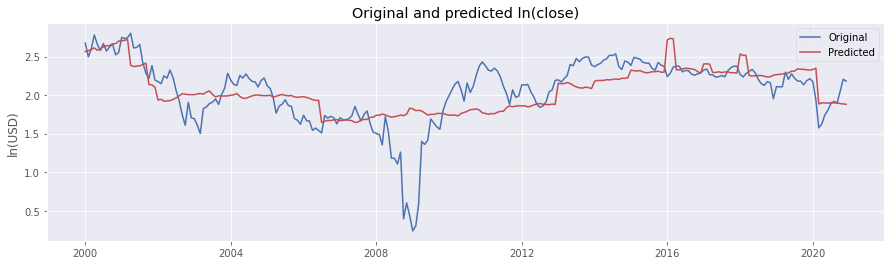

In [11]:
# Obtains the predicted ln(close)
df['pred_log_close'] = 0
for coeff, p_value, param in zip(model_fit.params, model_fit.pvalues, dict(model_fit.params).keys()):
    if p_value <= 0.1:
        if param == 'Intercept':
            df['pred_log_close'] += coeff
        else:
            df['pred_log_close'] += coeff*df[param]

# Plots
plt.plot(df['log_close'], label="Original")
plt.plot(df['pred_log_close'], label="Predicted")
plt.title("Original and predicted ln(close)")
plt.ylabel("ln(USD)")
plt.legend()
plt.show()


## Error Correcting Equation

The deviation $Z_{t−1}$ of the current log-price from its fundamental log-value at date $t−1$ contributes to an error correcting mechanism, according to:

In [12]:
# Creates and obtains the results of the OLS model
model = smf.ols('log_close.diff() ~ log_close.diff().shift(1) + resid.shift(1)', data=df)
model_fit = model.fit()

# Prints results
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       log_close.diff()   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.356
Date:                Sun, 17 Oct 2021   Prob (F-statistic):             0.0138
Time:                        19:33:50   Log-Likelihood:                 160.61
No. Observations:                 250   AIC:                            -315.2
Df Residuals:                     247   BIC:                            -304.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

If $Z_{t−1} > 0$ the index is overvalued at date $t−1$ and the term of $Z_{t−1}$ contributes to decrease $\Delta log(close)_t$ between dates $t−1$ and $t$ and accordingly the log-close at date $t$, $log(close)_t$, in order to bring it back to the fundamental log-value.